# Generative Adverserial Networks (GANs)

This file will show you how to set up a standard GAN.

In [1]:
# Standard imports

import numpy as np
import matplotlib.pyplot as plt 
import keras
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.datasets import mnist
from tensorflow.keras.metrics import Mean
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.optimizers import Adam
import tensorflow as tf



In [2]:
# We now load the test data and reshape it to a 784 element vector

def load_data():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = (x_train.astype(np.float32) - 127.5) / 127.5
    
    # Reshape from 28x28 image to 784 element vector
    x_train = x_train.reshape(x_train.shape[0], 784)

    return (x_train, y_train, x_test, y_test)

(x_train, y_train, x_test, y_test) = load_data()



In [3]:
# Load the Adam optimizer

def adam_optimizer():
    return Adam(learning_rate = 0.0002, beta_1 = 0.5)

In [4]:
# We now create the generator. This will take a random number and produce an image as a 
# 784 element array to fool the discriminator

def create_generator():
    generator = Sequential()
    generator.add(Dense(units = 256, input_dim = 100))
    generator.add(LeakyReLU(0.2))
    generator.add(Dense(units = 512))
    generator.add(LeakyReLU(0.2))
    generator.add(Dense(units = 784, activation = 'tanh'))
    generator.compile(loss = 'binary_crossentropy', optimizer = adam_optimizer())

    return generator
    

In [5]:
# Create the discriminator. This will learn btween fake and real images

def create_discriminator():
    discriminator = Sequential()
    discriminator.add(Dense(units = 1024, input_dim = 784))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(units = 512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(units = 256))
    discriminator.add(LeakyReLU(0.2))

    discriminator.add(Dense(units = 1, activation = 'sigmoid'))

    discriminator.compile(loss = 'binary_crossentropy', optimizer = adam_optimizer())
    return discriminator


In [6]:
# We now create the GAN

# Create the GAN
def create_gan(discriminator, generator):
    discriminator.trainable = False
    gan_input = Input(shape = (100,))
    x = generator(gan_input)
    gan_output = discriminator(x)
    gan = Model(inputs = gan_input, outputs = gan_output)
    gan.compile(loss = 'binary_crossentropy', optimizer = 'adam')
    return gan


In [7]:
# Utikity function to print the output images

# Display images
def plot_generated_images(epoch, generator, examples = 100, dim = (10, 10), figsize = (10, 10)):
    print("GENERATING TEST IMAGS")
    
    noise = np.random.normal(loc = 0, scale = 1, size = [examples, 100])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(100, 28, 28)
    plt.figure(figsize = figsize)

    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i + 1)
        plt.imshow(generated_images[i], interpolation = 'nearest', cmap='gray')
        plt.axis('off')

    plt.tight_layout()
    plt.savefig('gan_generated_image %d.png' %epoch)
    plt.show()

In [8]:
# Training Routine

def training(epochs = 1, batch_size = 128):
    # Load the training data
    (X_train, y_train, X_test, y_test) = load_data()
    batch_count = X_train.shape[0] / batch_size

    # Create the GAN
    generator = create_generator()
    discriminator = create_discriminator()
    gan = create_gan(discriminator, generator)
    
    tf.keras.utils.disable_interactive_logging()

    gen_loss = Mean()
    dis_loss = Mean()
    
    for e in range(1, epochs + 1):
        print("Epoch %d." % e)
        for _ in range(batch_size):

            # Generate random noise
            noise = np.random.normal(0, 1, [batch_size, 100])

            # Generate fake images
            generated_images = generator.predict(noise)

            # Get a random batch of real images
            image_batch = X_train[np.random.randint(low = 0, high = X_train.shape[0], size = batch_size)]
            X = np.concatenate([image_batch, generated_images])

            # Labels for the real and fake data
            y_dis = np.zeros(2 * batch_size)

            # Real data labels
            y_dis[:batch_size] = 0.9

            # Pretrain the discriminator on real and fake images 
            # before starting the GAN

            discriminator.trainable = True
            loss = discriminator.train_on_batch(X, y_dis)

            dis_loss.update_state(loss)
            
            # Create fake data and fake labels
            noise = np.random.normal(0, 1, [batch_size, 100])
            y_gen = np.ones(batch_size)

            # We freeze the discriminator while training the GAN
            # So we alternate between training the discriminator
            # and the GAN

            discriminator.trainable = False
            loss = gan.train_on_batch(noise, y_gen)
            gen_loss.update_state(loss)
            
        print("Generator Loss: ", gen_loss.result().numpy(), " Discriminator loss: ", 
              dis_loss.result().numpy())
        
        if (e == 1) or (e % 20 == 0):
            plot_generated_images(e, generator)
    tf.keras.utils.enable_interactive_logging()


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1.
Generator Loss:  3.2720895  Discriminator loss:  0.3781009
GENERATING TEST IMAGS


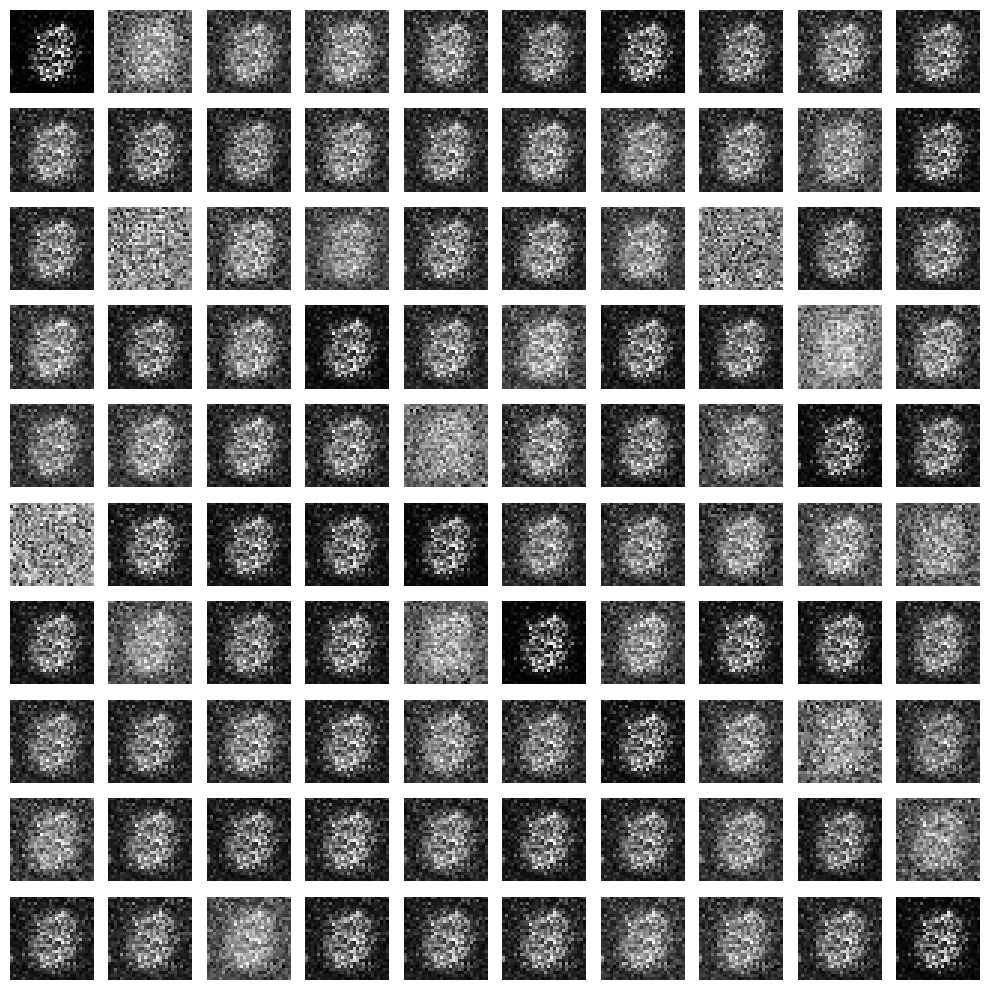

Epoch 2.
Generator Loss:  3.3300416  Discriminator loss:  0.35681975
Epoch 3.
Generator Loss:  3.1971753  Discriminator loss:  0.34817985
Epoch 4.
Generator Loss:  3.1409614  Discriminator loss:  0.3409824
Epoch 5.
Generator Loss:  3.1176212  Discriminator loss:  0.337012
Epoch 6.
Generator Loss:  3.1022177  Discriminator loss:  0.33536473
Epoch 7.
Generator Loss:  3.0932176  Discriminator loss:  0.3348967
Epoch 8.
Generator Loss:  3.0843422  Discriminator loss:  0.33498716
Epoch 9.
Generator Loss:  3.0759208  Discriminator loss:  0.33537495
Epoch 10.
Generator Loss:  3.0679848  Discriminator loss:  0.33590895
Epoch 11.
Generator Loss:  3.058283  Discriminator loss:  0.3367513
Epoch 12.
Generator Loss:  3.0471556  Discriminator loss:  0.33782557
Epoch 13.
Generator Loss:  3.0341456  Discriminator loss:  0.33914158
Epoch 14.
Generator Loss:  3.0197651  Discriminator loss:  0.3405539
Epoch 15.
Generator Loss:  3.0041764  Discriminator loss:  0.34211853
Epoch 16.
Generator Loss:  2.987617

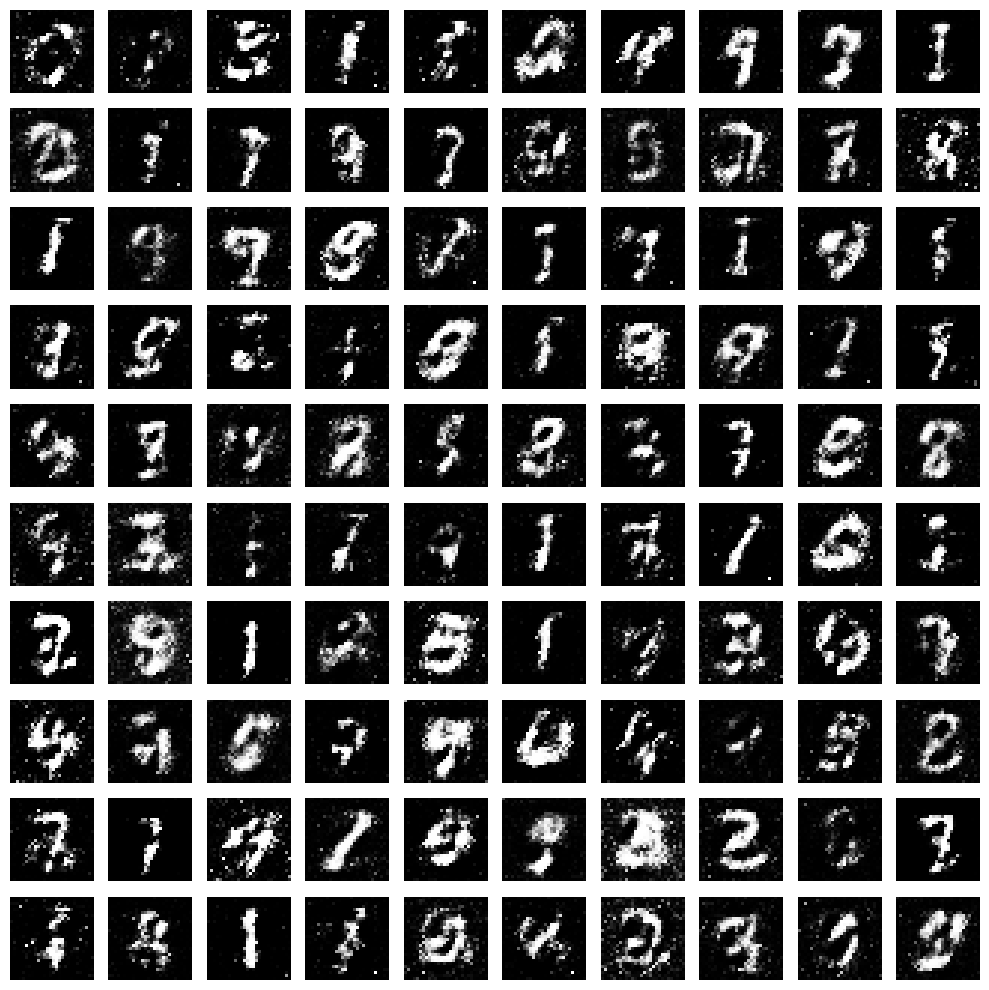

Epoch 21.
Generator Loss:  2.899755  Discriminator loss:  0.35358542
Epoch 22.
Generator Loss:  2.8816626  Discriminator loss:  0.35569385
Epoch 23.
Generator Loss:  2.8637087  Discriminator loss:  0.35779276
Epoch 24.
Generator Loss:  2.8459985  Discriminator loss:  0.3598752
Epoch 25.
Generator Loss:  2.8285327  Discriminator loss:  0.36194825
Epoch 26.
Generator Loss:  2.8112738  Discriminator loss:  0.36401656
Epoch 27.
Generator Loss:  2.7942164  Discriminator loss:  0.3660763
Epoch 28.
Generator Loss:  2.7773552  Discriminator loss:  0.36813012
Epoch 29.
Generator Loss:  2.7607443  Discriminator loss:  0.37016666
Epoch 30.
Generator Loss:  2.7444036  Discriminator loss:  0.37217578
Epoch 31.
Generator Loss:  2.7283826  Discriminator loss:  0.3741526
Epoch 32.
Generator Loss:  2.7126732  Discriminator loss:  0.37609756
Epoch 33.
Generator Loss:  2.6972535  Discriminator loss:  0.37801385
Epoch 34.
Generator Loss:  2.6821318  Discriminator loss:  0.37989965
Epoch 35.
Generator Loss

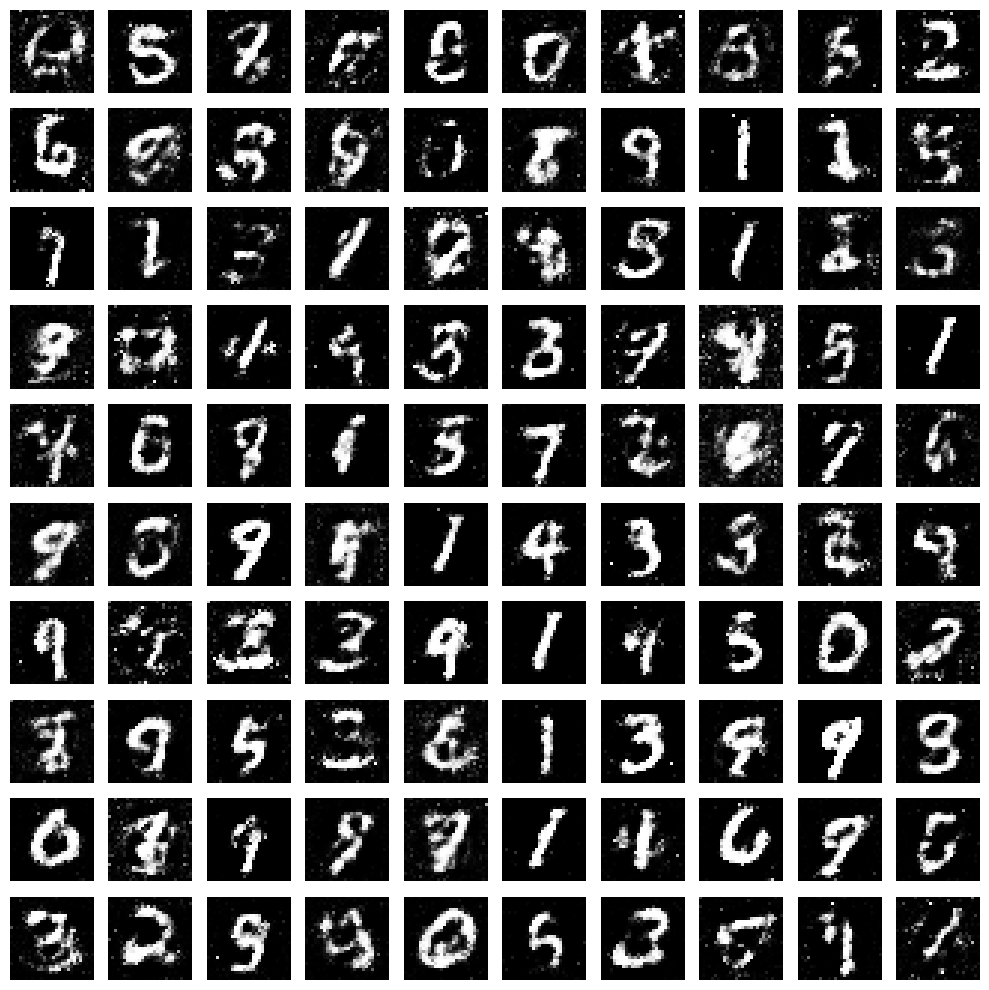

Epoch 41.
Generator Loss:  2.5848281  Discriminator loss:  0.39215285
Epoch 42.
Generator Loss:  2.572082  Discriminator loss:  0.3937734
Epoch 43.
Generator Loss:  2.5596228  Discriminator loss:  0.39536196
Epoch 44.
Generator Loss:  2.5474563  Discriminator loss:  0.39691743
Epoch 45.
Generator Loss:  2.5355387  Discriminator loss:  0.3984436
Epoch 46.
Generator Loss:  2.5238783  Discriminator loss:  0.39994183
Epoch 47.
Generator Loss:  2.5124724  Discriminator loss:  0.4014113
Epoch 48.
Generator Loss:  2.501294  Discriminator loss:  0.40285525
Epoch 49.
Generator Loss:  2.4903436  Discriminator loss:  0.40427345
Epoch 50.
Generator Loss:  2.4796393  Discriminator loss:  0.4056623
Epoch 51.
Generator Loss:  2.4691567  Discriminator loss:  0.4070244
Epoch 52.
Generator Loss:  2.4588735  Discriminator loss:  0.40836424
Epoch 53.
Generator Loss:  2.4487882  Discriminator loss:  0.4096808
Epoch 54.
Generator Loss:  2.438906  Discriminator loss:  0.41097313
Epoch 55.
Generator Loss:  2.

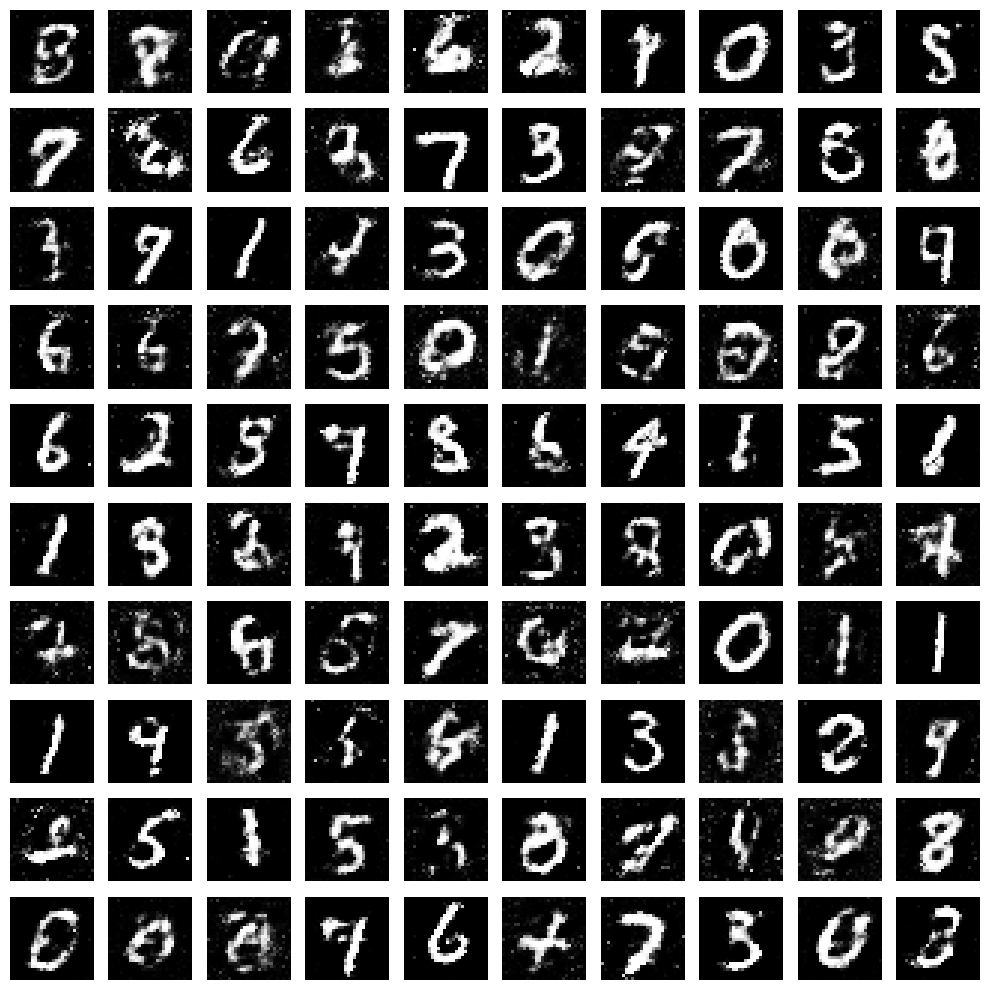

Epoch 61.
Generator Loss:  2.3748283  Discriminator loss:  0.41941902
Epoch 62.
Generator Loss:  2.366333  Discriminator loss:  0.42054728
Epoch 63.
Generator Loss:  2.357983  Discriminator loss:  0.4216585
Epoch 64.
Generator Loss:  2.3497753  Discriminator loss:  0.4227532
Epoch 65.
Generator Loss:  2.3417046  Discriminator loss:  0.42383173
Epoch 66.
Generator Loss:  2.333767  Discriminator loss:  0.42489368
Epoch 67.
Generator Loss:  2.325959  Discriminator loss:  0.4259399
Epoch 68.
Generator Loss:  2.3182902  Discriminator loss:  0.4269685
Epoch 69.
Generator Loss:  2.3107517  Discriminator loss:  0.4279806
Epoch 70.
Generator Loss:  2.303333  Discriminator loss:  0.428978
Epoch 71.
Generator Loss:  2.2960384  Discriminator loss:  0.4299597
Epoch 72.
Generator Loss:  2.2888658  Discriminator loss:  0.43092617
Epoch 73.
Generator Loss:  2.281807  Discriminator loss:  0.43187797
Epoch 74.
Generator Loss:  2.2748797  Discriminator loss:  0.43281358
Epoch 75.
Generator Loss:  2.26806

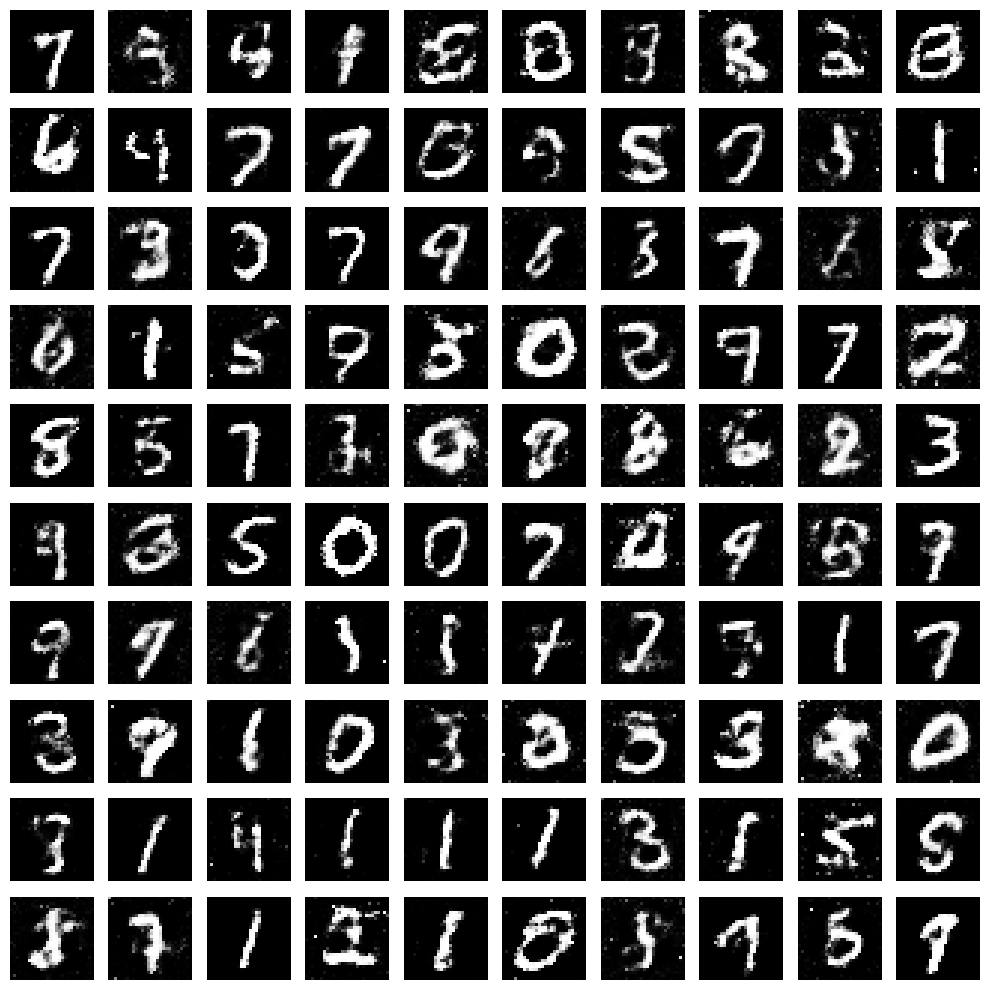

Epoch 81.
Generator Loss:  2.2294443  Discriminator loss:  0.4389689
Epoch 82.
Generator Loss:  2.223357  Discriminator loss:  0.43979734
Epoch 83.
Generator Loss:  2.217369  Discriminator loss:  0.44061294
Epoch 84.
Generator Loss:  2.2114766  Discriminator loss:  0.4414161
Epoch 85.
Generator Loss:  2.205672  Discriminator loss:  0.4422084
Epoch 86.
Generator Loss:  2.1999514  Discriminator loss:  0.44298983
Epoch 87.
Generator Loss:  2.19432  Discriminator loss:  0.44375962
Epoch 88.
Generator Loss:  2.1887748  Discriminator loss:  0.4445179
Epoch 89.
Generator Loss:  2.1833138  Discriminator loss:  0.44526532
Epoch 90.
Generator Loss:  2.1779351  Discriminator loss:  0.44600207
Epoch 91.
Generator Loss:  2.1726341  Discriminator loss:  0.4467286
Epoch 92.
Generator Loss:  2.1674104  Discriminator loss:  0.44744533
Epoch 93.
Generator Loss:  2.1622627  Discriminator loss:  0.44815195
Epoch 94.
Generator Loss:  2.1571891  Discriminator loss:  0.44884858
Epoch 95.
Generator Loss:  2.1

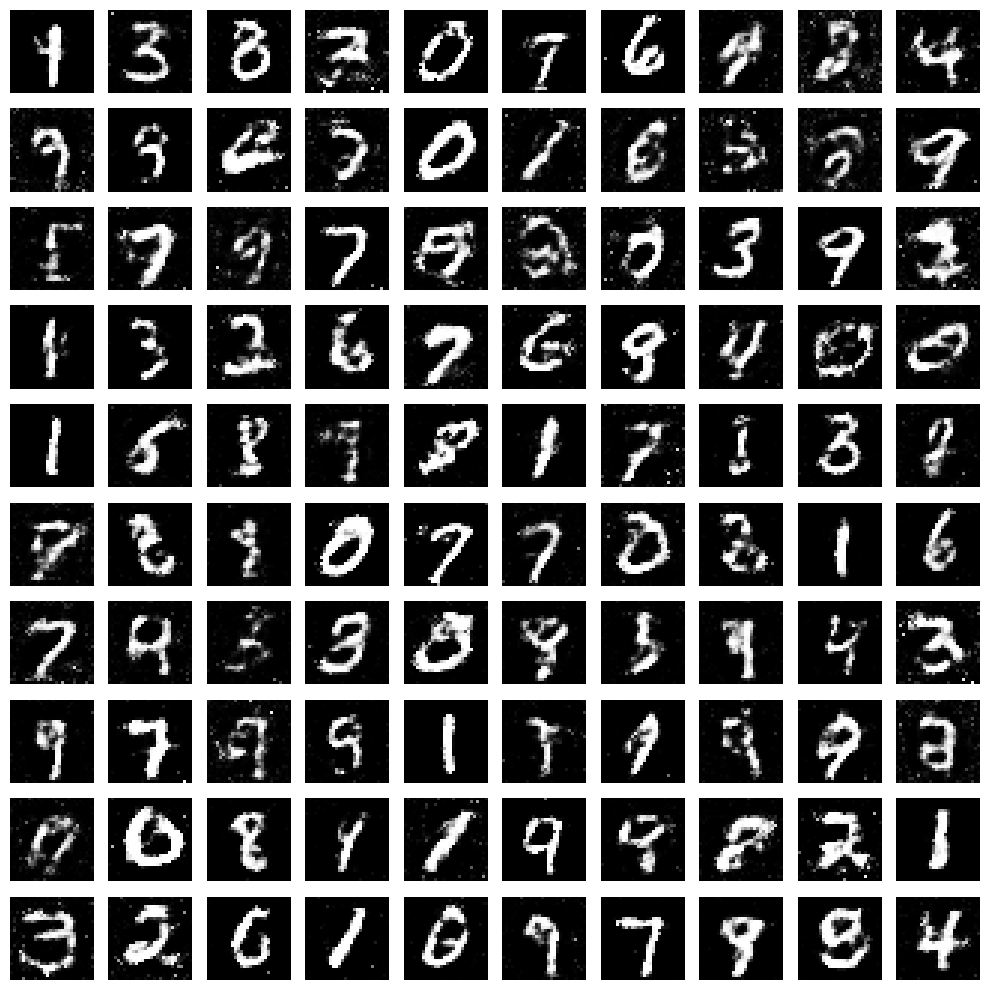

Epoch 101.
Generator Loss:  2.123679  Discriminator loss:  0.45346174
Epoch 102.
Generator Loss:  2.1191552  Discriminator loss:  0.454086
Epoch 103.
Generator Loss:  2.11469  Discriminator loss:  0.4547025
Epoch 104.
Generator Loss:  2.1102839  Discriminator loss:  0.45531178
Epoch 105.


KeyboardInterrupt: 

In [9]:
# Run the model
training(epochs = 400, batch_size = 128)